In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA

# Basics

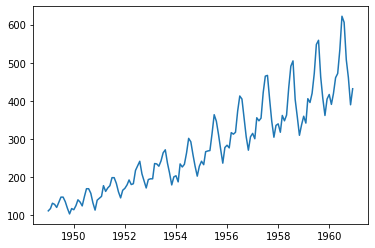

In [2]:
# Load the data using pandas and parse the time data to use them as an index
air_data = pd.read_csv("../datasets/AirPassengers.csv", index_col=0, parse_dates=True)
# convert the df to a Series object
ts = air_data['#Passengers']
# plot the data
plt.plot(ts)
plt.show()

In [3]:
def test_stationarity(ts):
    
    ### Method 1: Calculate and plot rolling statistics like the mean and standard deviation
    roll_mean = ts.rolling(window=12).mean()
    roll_std = ts.rolling(window=12).std()
     
    plt.plot(ts, color="blue", label="Original TS")
    plt.plot(roll_mean, color="red", label="Rolling Mean")
    plt.plot(roll_std, color="green", label="Rolling STD")
    plt.legend(loc="best")
    plt.show()
    
    ### Method 2: Use the Dickey-Fuller statistical test 
    print("Performing Dickey-Fuller statistical test...")
    dftest = adfuller(ts, autolag="AIC")
    
    test_results = pd.Series(dftest[0:4], index=["Test statistic", "p-value", "#Lags used", "#Observations used"])
    for key, alpha_lvl in dftest[4].items():
        test_results['Critical Value (%s)'%key] = alpha_lvl
    print(test_results)

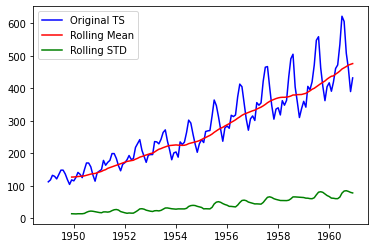

Performing Dickey-Fuller statistical test...
Test statistic            0.815369
p-value                   0.991880
#Lags used               13.000000
#Observations used      130.000000
Critical Value (1%)      -3.481682
Critical Value (5%)      -2.884042
Critical Value (10%)     -2.578770
dtype: float64


In [4]:
test_stationarity(ts)

# Eliminating trend

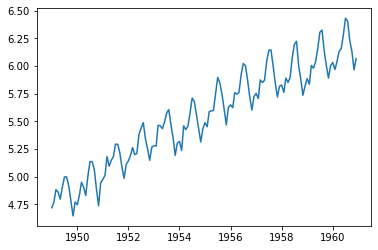

In [5]:
# Firstly let's transform the series. Transformations that penalise higher values work well 
# for series with increasing trend
ts_log = np.log(ts)
plt.plot(ts_log)
plt.show()

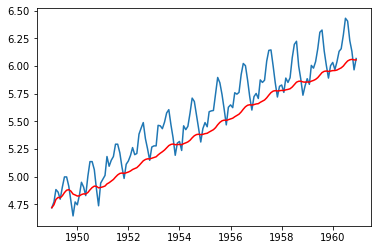

In [6]:
# Use exponential weighted moving average to eliminate trend
expw_avg = ts_log.ewm(halflife=12).mean()
plt.plot(ts_log)
plt.plot(expw_avg, color="red", label="Exp weighted moving average")
plt.show()

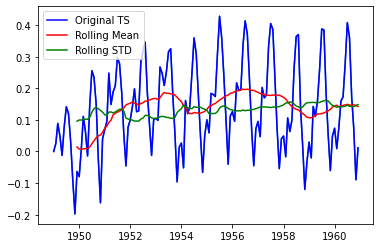

Performing Dickey-Fuller statistical test...
Test statistic           -3.601262
p-value                   0.005737
#Lags used               13.000000
#Observations used      130.000000
Critical Value (1%)      -3.481682
Critical Value (5%)      -2.884042
Critical Value (10%)     -2.578770
dtype: float64


In [7]:
ewma_diff_series = ts_log - expw_avg
plt.plot(ewma_diff_series)
test_stationarity(ewma_diff_series)

# Eliminating Trend and Seasonality

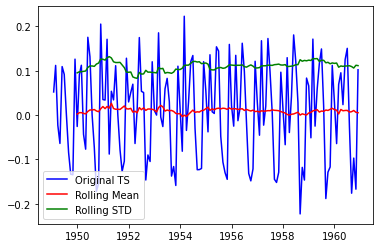

Performing Dickey-Fuller statistical test...
Test statistic           -2.717131
p-value                   0.071121
#Lags used               14.000000
#Observations used      128.000000
Critical Value (1%)      -3.482501
Critical Value (5%)      -2.884398
Critical Value (10%)     -2.578960
dtype: float64


In [8]:
# Differencing
ts_log_diff = ts_log - ts_log.shift()
ts_log_diff.dropna(inplace=True)
test_stationarity(ts_log_diff)

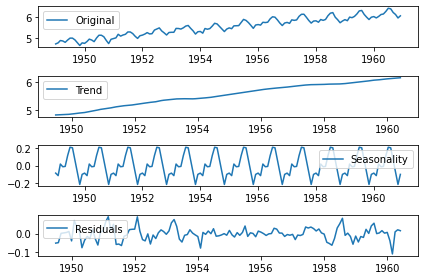

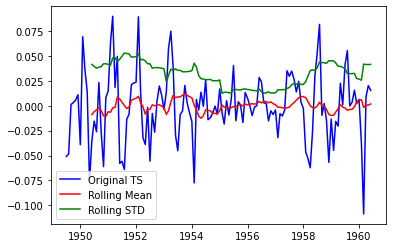

Performing Dickey-Fuller statistical test...
Test statistic         -6.332387e+00
p-value                 2.885059e-08
#Lags used              9.000000e+00
#Observations used      1.220000e+02
Critical Value (1%)    -3.485122e+00
Critical Value (5%)    -2.885538e+00
Critical Value (10%)   -2.579569e+00
dtype: float64


In [9]:
# Decomposition
ts_decomp = seasonal_decompose(ts_log)
trend = ts_decomp.trend
seasonality = ts_decomp.seasonal
residuals = ts_decomp.resid

# Plot decomposition results 
plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonality,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residuals, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

# Test stationarity of residuals (what remains after removing trend and seasonality)
ts_log_decompose = residuals
ts_log_decompose.dropna(inplace=True)
test_stationarity(ts_log_decompose)

# Forecasting

/Users/Geri/.local/share/virtualenvs/thesis-0Scq67eD/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:572: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning


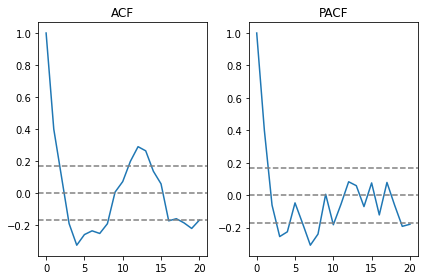

In [10]:
# In this case ARIMA will be used to forecast. To check our AR and MA parameters (p and q) we'll need to plot
# the acf and pacf. Of course we can run auto-arima procedures but this is more manual
log_acf = acf(ts_log_decompose, nlags=20)
log_pacf = pacf(ts_log_decompose, nlags=20, method="ols")

plt.subplot(121)
plt.plot(log_acf)
plt.axhline(y=0, linestyle="--", color="gray")
plt.axhline(y=1.96/np.sqrt(len(ts_log_decompose)), linestyle="--", color="gray")
plt.axhline(y=-1.96/np.sqrt(len(ts_log_decompose)), linestyle="--", color="gray")
plt.title("ACF")
plt.subplot(122)
plt.plot(log_pacf)
plt.axhline(y=0, linestyle="--", color="gray")
plt.axhline(y=1.96/np.sqrt(len(ts_log_decompose)), linestyle="--", color="gray")
plt.axhline(y=-1.96/np.sqrt(len(ts_log_decompose)), linestyle="--", color="gray")
plt.title("PACF")
plt.tight_layout()
plt.show()

In [11]:
# Use ARIMA to fun a forecast on the series
arima_model = ARIMA(ts_log, order=(2,1,2))
arima_results = arima_model.fit(disp=-1)

/Users/Geri/.local/share/virtualenvs/thesis-0Scq67eD/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/Geri/.local/share/virtualenvs/thesis-0Scq67eD/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


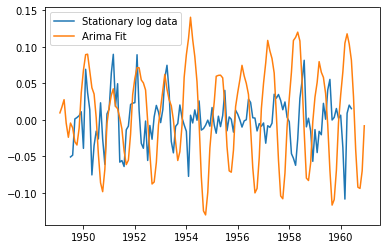

In [12]:
plt.plot(ts_log_decompose, label="Stationary log data")
plt.plot(arima_results.fittedvalues, label="Arima Fit")
plt.legend(loc="best")
plt.show()

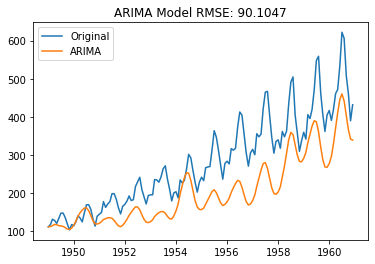

In [13]:
# The last step is to convert the fitted values back to the original scale

# First we need to get the differenced series back to log scale
predicted_arima_diff = arima_results.fittedvalues
predicted_arima_diff_cumsum = predicted_arima_diff.cumsum()
predicted_arima_log = pd.Series(ts_log.iloc[0], index=ts_log.index)
predicted_arima_log = predicted_arima_log.add(predicted_arima_diff_cumsum, fill_value=0)
# Then we take the exponent to convert the log scale to the original scale
predictions_arima = np.exp(predicted_arima_log)
rmse = np.sqrt(sum((predictions_arima-ts)**2)/len(ts))
# Plot the final results
plt.plot(ts, label="Original")
plt.plot(predictions_arima, label="ARIMA")
plt.title("ARIMA Model RMSE: %.4f"%rmse)
plt.legend(loc="best")
plt.show()